# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_theme(style="white", context="notebook", palette="deep")
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, KFold

# Functions

In [17]:
def random_SCV(pipe = [],
               grid_param = [],
               n_iter = 10,
               cv = 5,
               scoring = "neg_mean_squared_error",
               rnd_state = 42,
               file_name = "",
               training = []):
    rnd_search = RandomizedSearchCV(pipe, param_distributions=grid_param, n_iter=n_iter, cv=cv, scoring=scoring, verbose=100000)
    rnd_search.fit(training[0], training[1])
    wr_pkl_file(file_name, rnd_search, False)

def grid_SCV(pipe = [], grid_param = [], cv = 5, scoring = "neg_mean_squared_error", file_name = "", training = []):
    rnd_search = GridSearchCV(pipe, grid_param, cv=cv, scoring=scoring, verbose=100)
    rnd_search.fit(training[0], training[1])
    wr_pkl_file(file_name, rnd_search, False)

def wr_pkl_file(file_name = "", content = "", read = False):
    if file_name:
        path_ = "./param_tuning/" + file_name
        if read:
            return joblib.load(path_)
        else:
            if content:
                joblib.dump(content, path_)

def print_results(labels = [], est = [], plt_num = 50, testing = []):
    col = 1
    plt.rcParams['figure.figsize'] = (30,15)
    for name, clf in zip(labels,est):
        print(name)

        df_labels_prediction = clf.predict(testing[0])

        print("R-Squared: {:.3f}".format(r2_score(np.exp(testing[1]), np.exp(df_labels_prediction))))
        mse = mean_squared_error(np.exp(testing[1]), np.exp(df_labels_prediction))
        mae = mean_absolute_error(np.exp(testing[1]), np.exp(df_labels_prediction))

        rmse = np.sqrt(mse)
        print("Root Mean Suqre Error: {:,.3f}".format(rmse))
        print("Mean Absolute Error: {:,.3f}".format(mae))
        print()

        plt.subplot(3,1,col)

        plt.title(name.replace(":", ""), fontsize= 18)
        plt.xticks(fontsize = 18)
        plt.yticks(fontsize = 18)
        plt.plot(range(plt_num), np.exp(df_labels_prediction)[:plt_num], "*-", label="model prediction")
        plt.plot(range(plt_num), np.exp(testing[1])[:plt_num], "o--", label="true value")
        plt.legend()
        col += 1

def validation(models = [], estimators = [], training = [], cv = 5, train_score = False):
    if len(models) != len(estimators):
        print("Error: Model Names And Estimator Must Have The Same Length")
        return
    
    for model, estimator in zip(models, estimators):
        scores = cross_validate(estimator, training[0], training[1], cv=cv, scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"), return_train_score=train_score)
    
        print(model)
        print("R-Squared: {:,.3f}".format(np.mean(scores["test_r2"])))
        print("Root Mean Squared Error: {:,.3f}".format(np.mean(np.sqrt(-scores["test_neg_mean_squared_error"]))))
        print("Mean Absolute Error: {:,.3f}".format(np.mean(-scores["test_neg_mean_absolute_error"])))
        print()

# Data Cleaning

In [3]:
url = "https://drive.google.com/file/d/1Q3_zadThHAeiEJNU-ieZJy3oIFs5QXdp/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]

df  = pd.read_csv(path)

df.replace(" -  ", np.nan, inplace=True)

df.drop(['Region', 'Type of Household', 'House Age', 'Members with age less than 5 year old',
         'Members with age 5 - 17 years old', 'Number of Landline/wireless telephones',
         'Number of Motorized Banca', "Number of Television", "Number of CD/VCD/DVD", 
         "Number of Component/Stereo set", "Number of Refrigerator/Freezer",
         "Number of Washing Machine", "Number of Airconditioner", "Number of Car, Jeep, Van", 
         "Number of Landline/wireless telephones","Number of Cellular phone","Number of Personal Computer",
         "Number of Stove with Oven/Gas Range","Number of Motorized Banca","Number of Motorcycle/Tricycle"], axis=1, inplace=True)

floats = ["Staple Food Expenditure", "Meat Expenditure", "Seafood Expenditure",
          "Medical Expenditure", "Transportation Expenditure", "Utilities Expenditure",
          "Education Expenditure", "Total Household Income", "House Floor Area"]

for col in floats:
    df[col] = pd.to_numeric(df[col], errors="coerce")

categorical_columns = ['Household Head Gender', 'Household Head Marital Status', 
                       'Household Head Highest Grade Completed', 'Household Head Job Indicator', 
                       'Household Head Occupation', 'Household Head Class of Worker', 'Tenure Status',
                       'Source of Income', 'Main Source of Water Supply']

for col in categorical_columns:
    df[col] = df[col].str.strip()

df = df[df['Total Household Income'] > 0]
df = df[df['Total Number of Family members'] > 0]

df.drop(labels=['Household Head Job Indicator'], axis=1, inplace=True)

print("Shape before removing duplicates:", df.shape)
df.drop_duplicates(inplace=True)
print("Shape after removing duplicates:", df.shape)

df.dropna(inplace=True)

print(df.head())

label_encoder = lambda x: {uniq: i for i, uniq in enumerate(df[x].unique().tolist())}

Shape before removing duplicates: (41544, 31)
Shape after removing duplicates: (41544, 31)
   Total Household Income  Staple Food Expenditure Source of Income  \
0                    9370                     1736             Wage   
1                    3540                      718             Wage   
2                    1478                     1281             Wage   
3                    2199                     1273             Wage   
4                    4732                     1386             Wage   

   Agricultural Household indicator  Meat Expenditure  Seafood Expenditure  \
0                                 0               441                  300   
1                                 0               311                  198   
2                                 1               139                   46   
3                                 0               195                  193   
4                                 0               328                  202   

   Leisure Ex

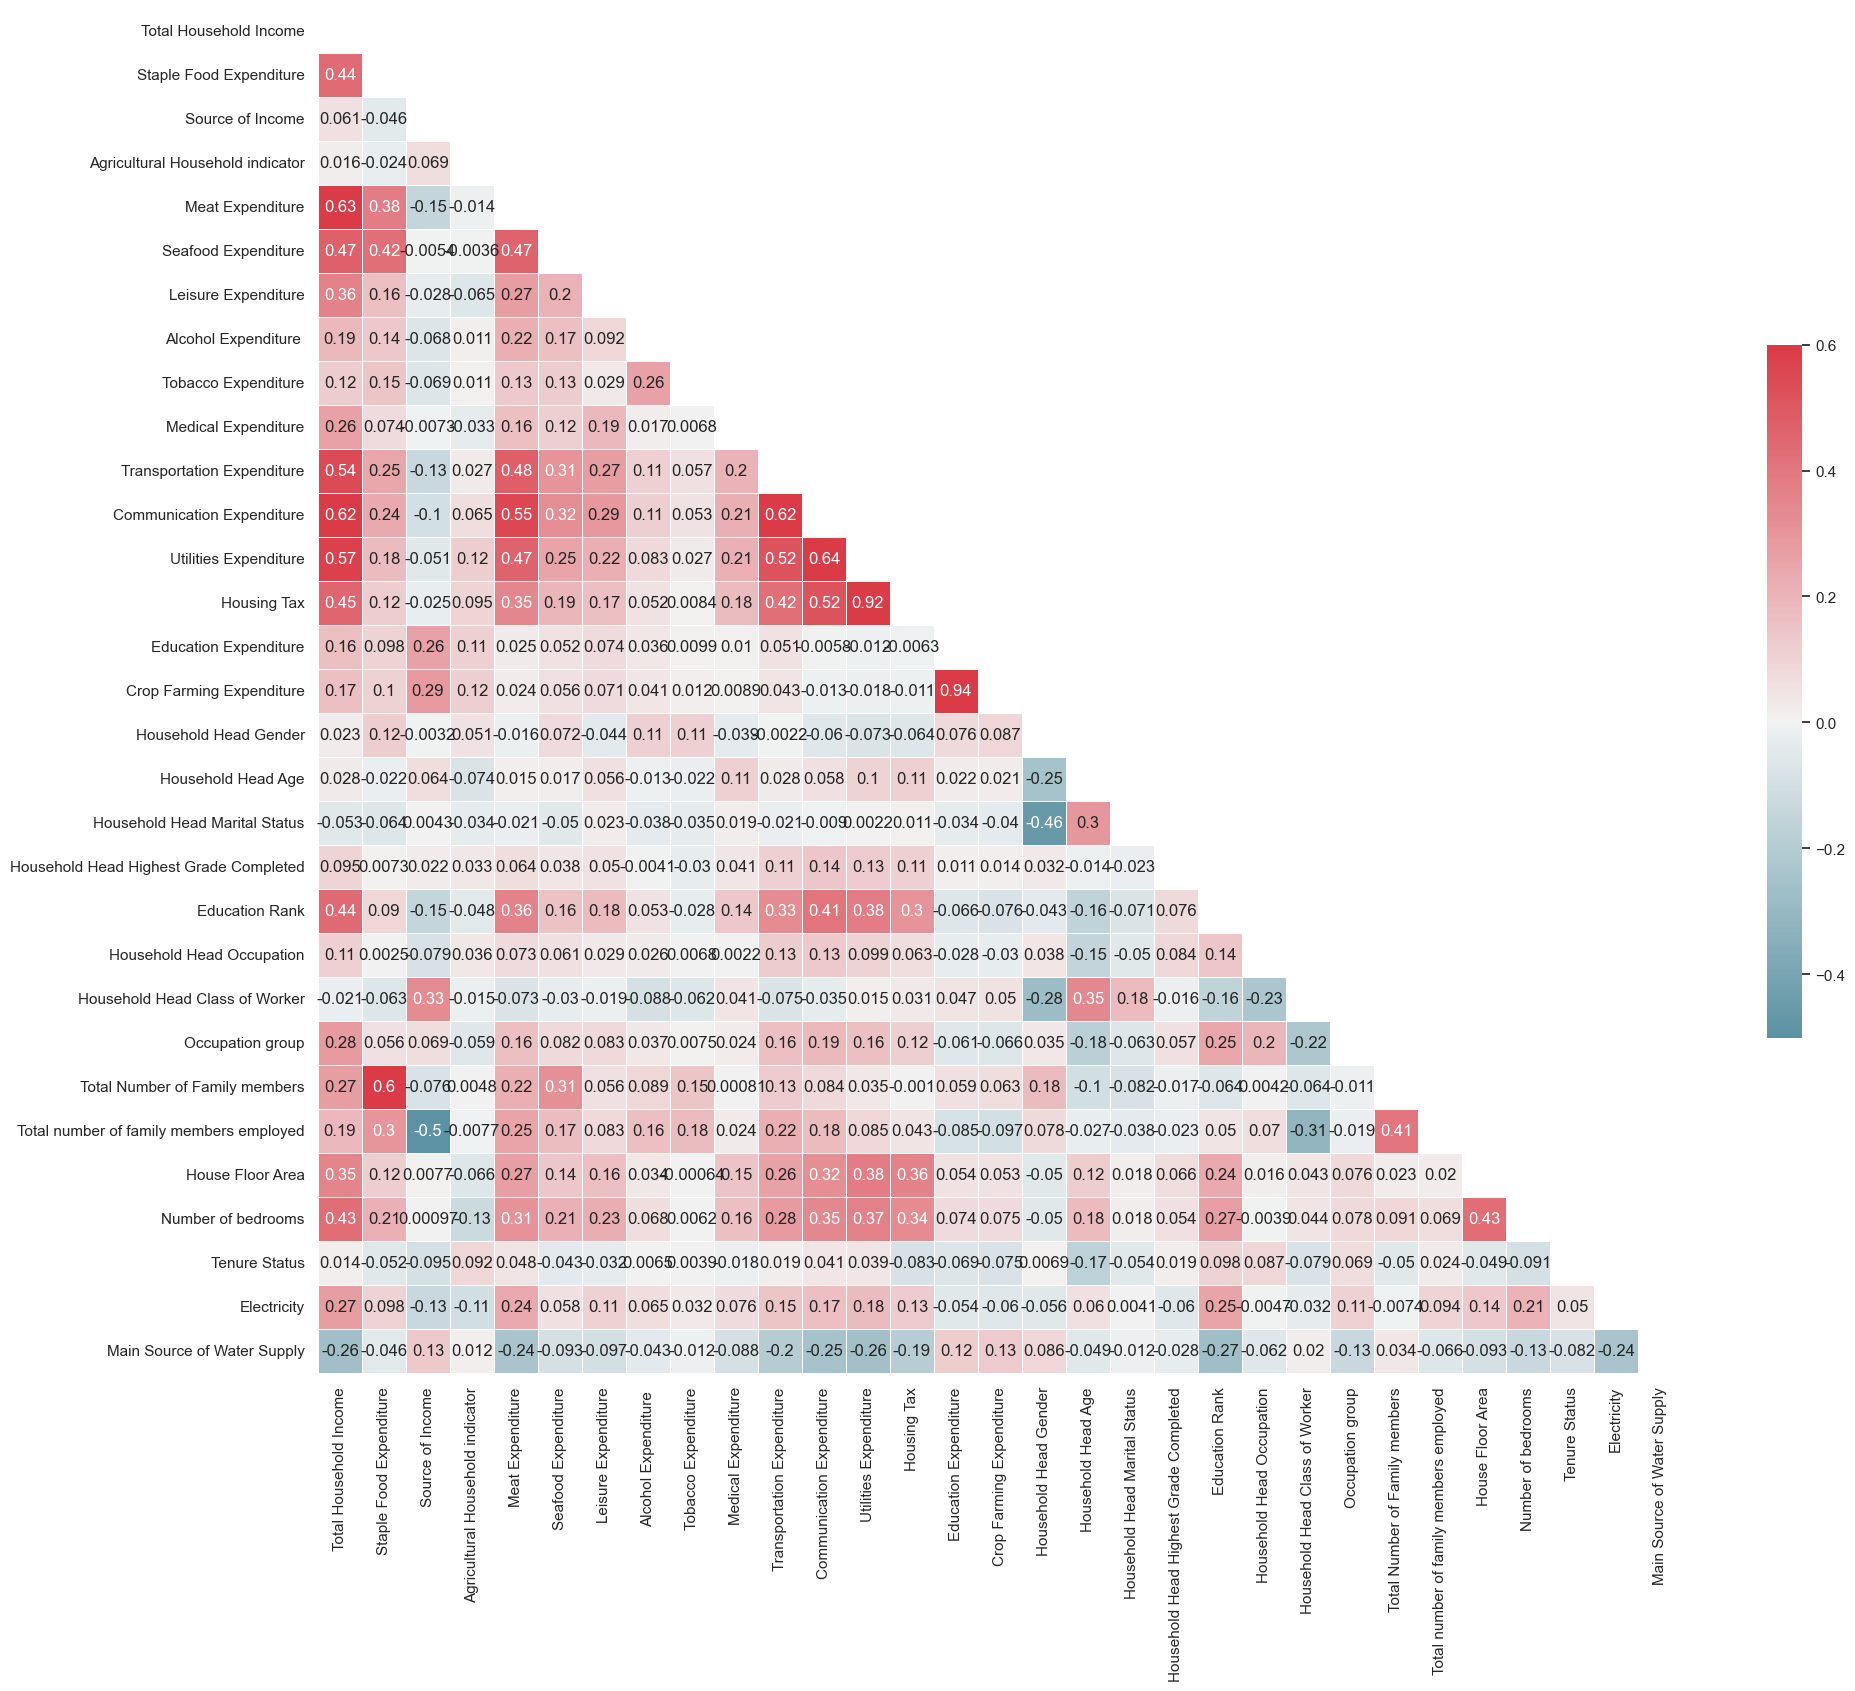

In [4]:
df_copy = df.copy()

df_copy['Total Household Income'] = np.log(df_copy['Total Household Income'])

df_copy['Household Head Gender'] = df_copy['Household Head Gender'].map(label_encoder("Household Head Gender"))
df_copy['Household Head Marital Status'] = df_copy['Household Head Marital Status'].map(label_encoder("Household Head Marital Status"))
df_copy['Household Head Highest Grade Completed'] = df_copy['Household Head Highest Grade Completed'].map(label_encoder("Household Head Highest Grade Completed"))
df_copy['Household Head Occupation'] = df_copy['Household Head Occupation'].map(label_encoder("Household Head Occupation"))
df_copy['Household Head Class of Worker'] = df_copy['Household Head Class of Worker'].map(label_encoder("Household Head Class of Worker"))
df_copy['Tenure Status'] = df_copy['Tenure Status'].map(label_encoder("Tenure Status"))
df_copy['Source of Income'] = df_copy['Source of Income'].map(label_encoder("Source of Income"))
df_copy['Main Source of Water Supply'] = df_copy['Main Source of Water Supply'].map(label_encoder("Main Source of Water Supply"))

sns.set_theme(style="white")

corr = df_copy.corr(method="pearson")

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(22,18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

del df_copy


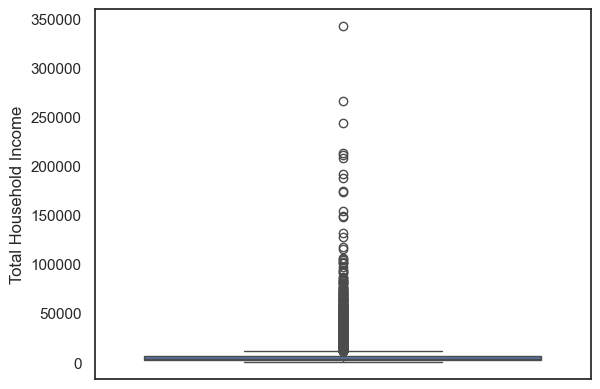

In [5]:
df_copy = df.copy()
sns.boxplot(df_copy["Total Household Income"])
test = df_copy[df_copy["Total Household Income"] > df_copy["Total Household Income"].quantile(0.90)]

<Axes: >

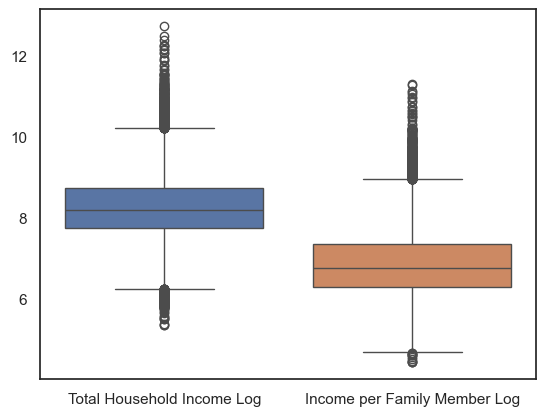

In [6]:
df_copy['Income per Family Member Log'] = np.log(df_copy['Total Household Income'] / df_copy['Total Number of Family members'])
df_copy['Total Household Income Log'] = np.log(df_copy['Total Household Income'])
sns.boxplot(data=df_copy[['Total Household Income Log', 'Income per Family Member Log']])

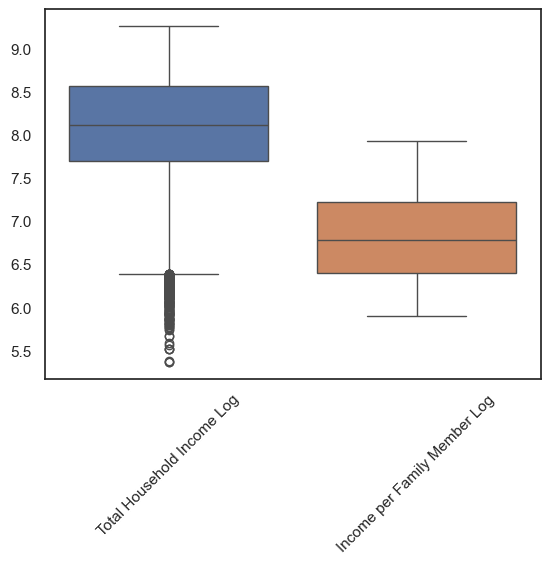

In [7]:
income_log_threshold_low = df_copy["Total Household Income Log"].quantile(0.10)
income_log_threshold_high = df_copy["Total Household Income Log"].quantile(0.90)

income_per_member_log_threshold_low = df_copy["Income per Family Member Log"].quantile(0.10)
income_per_member_log_threshold_high = df_copy["Income per Family Member Log"].quantile(0.90)

a = df_copy[df_copy['Total Household Income Log'] < income_log_threshold_high]
b = df_copy[(df_copy['Income per Family Member Log'] > income_per_member_log_threshold_low) & (df_copy['Income per Family Member Log'] < income_per_member_log_threshold_high)]
ax = sns.boxplot(data=[a['Total Household Income Log'], b['Income per Family Member Log']])
ax.set_xticklabels(['Total Household Income Log', 'Income per Family Member Log'], rotation=45)
del a,b

In [8]:
print(len(df_copy))
print(len(df_copy[(df_copy["Income per Family Member Log"] < income_per_member_log_threshold_high) | (df_copy["Income per Family Member Log"] > income_per_member_log_threshold_low)]))
print(len(df_copy[df_copy["Total Household Income Log"] > income_log_threshold_low]))
print(len(test))

41544
41544
37380
4155


# Machine Learning

## Preprocessing

In [48]:
def label_encode(column = ""):
    if column:
        df[column] = df[column].map(label_encoder(column))

label_encode("Household Head Gender")
label_encode("Household Head Marital Status")
label_encode("Household Head Highest Grade Completed")
label_encode("Household Head Occupation")
label_encode("Household Head Class of Worker")
label_encode("Tenure Status")
label_encode("Source of Income")

lr_df = df.copy()

df["Total Household Income Log"] = np.log(df["Total Household Income"])

modified_df = df[[
    "House Floor Area",
    "Staple Food Expenditure",
    "Meat Expenditure",
    "Seafood Expenditure",
    "Medical Expenditure",
    "Transportation Expenditure",
    "Utilities Expenditure",
    "Education Expenditure",
    "Household Head Gender",
    "Household Head Marital Status",
    "Household Head Highest Grade Completed",
    "Household Head Occupation",
    "Household Head Class of Worker",
    "Tenure Status",
    "Source of Income",
    "Total Number of Family members",
]]

y = df["Total Household Income Log"]

tr_x_train, tr_x_test, tr_y_train, tr_y_test = train_test_split(modified_df, y, test_size=0.2, random_state=42)

lr_df["Income per Family Member"] = lr_df["Total Household Income"] / lr_df["Total Number of Family members"]
lr_df["Income per Family Member Log"] = np.log(lr_df["Income per Family Member"])

lower_threshold = lr_df["Income per Family Member Log"].quantile(0.01)
upper_threshold = lr_df["Income per Family Member Log"].quantile(0.99)

lr_df = lr_df[(lr_df["Income per Family Member Log"] > lower_threshold) & (lr_df["Income per Family Member Log"] < upper_threshold)]

lr_modified = lr_df[[
    "House Floor Area",
    "Staple Food Expenditure",
    "Meat Expenditure",
    "Seafood Expenditure",
    "Medical Expenditure",
    "Transportation Expenditure",
    "Utilities Expenditure",
    "Education Expenditure",
    "Household Head Gender",
    "Household Head Marital Status",
    "Household Head Highest Grade Completed",
    "Household Head Occupation",
    "Household Head Class of Worker",
    "Tenure Status",
    "Source of Income",
    "Total Number of Family members",
    "Income per Family Member Log",
    "Total Household Income Log"
]]

train_set, test_set = train_test_split(lr_modified, test_size=0.4, random_state=42)

lr_y_train_ppu = train_set["Income per Family Member Log"].copy()
lr_y_train_ru = train_set["Total Number of Family members"].copy() # For cross-validation
lr_y_train = train_set["Total Household Income Log"].copy()        # For cross-validation
lr_x_train_ppu = train_set.drop(["Total Household Income Log", "Income per Family Member Log", "Total Number of Family members"], axis=1)

# Split data and target in test set
lr_y_test_ppu = test_set["Income per Family Member Log"].copy()
lr_y_test = test_set["Total Household Income Log"].copy()
lr_y_test_ru = test_set["Total Number of Family members"]
lr_x_test_ppu = test_set.drop(["Total Household Income Log", "Income per Family Member Log", "Total Number of Family members"], axis=1)

# Dummy Regressor

In [49]:
## Trees
print("Trees df")

# Initialize Dummy estimator 
dummy_regr = DummyRegressor(strategy="median")

# Train estimator
dummy_regr.fit(tr_x_train, tr_y_train)

# Predict 
preds = np.exp(dummy_regr.predict(tr_x_test))


# Calculate RMSE
mse = mean_squared_error(np.exp(tr_y_test), preds)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(tr_y_test), preds)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(tr_y_test), preds)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()


## Linear Regression
print("Linear Regression df")

# Initialize Dummy estimator 
lr_dummy_regr = DummyRegressor(strategy="median")

# Train estimator
lr_dummy_regr.fit(lr_x_train_ppu, lr_y_train_ppu)

# Predict 
lr_preds = np.exp(lr_dummy_regr.predict(lr_x_test_ppu))

# Calculate RMSE
mse = mean_squared_error(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)
rmse = np.sqrt(mse)

# Calculate MAE
mae = mean_absolute_error(np.exp(lr_y_test_ppu)* lr_y_test_ru, lr_preds * lr_y_test_ru)

# Print results
print("R-Squared: {:,.3f}".format(r2_score(np.exp(lr_y_test_ppu) * lr_y_test_ru, lr_preds * lr_y_test_ru)))
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

Trees df
R-Squared: -0.062
Root Mean Square Error: 6,945.049
Mean Absolute Error: 3,061.626

Linear Regression df
R-Squared: -0.023
Root Mean Square Error: 4,795.280
Mean Absolute Error: 2,865.860



## Pipeline

In [50]:
numeric_features = ['House Floor Area', 'Staple Food Expenditure', 'Meat Expenditure', 'Seafood Expenditure', 
                    'Medical Expenditure', 'Transportation Expenditure', 'Utilities Expenditure', 
                    'Education Expenditure']
categorical_features = ['Household Head Gender', 'Household Head Marital Status', 
                        'Household Head Highest Grade Completed', 'Household Head Occupation', 
                        'Household Head Class of Worker', 'Tenure Status', 'Source of Income']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

ohe_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', numeric_transformer, numeric_features),
        ('ohe', ohe_transformer, categorical_features),
    ])

X = df[numeric_features + categorical_features]
y = df['Total Household Income Log']

## ML Estimators

In [51]:
# Linear regression Estimator
lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', LinearRegression())])

# Decision Tree Regressor
dtr = Pipeline(steps=[
                      ('dtr', DecisionTreeRegressor())])

# Extra Tree Regressor
etr = Pipeline(steps=[
                      ('etr', BaggingRegressor(ExtraTreeRegressor(random_state=42),
                                                        random_state = 42))])
# Random Forest Regressor
rfrr = Pipeline(steps=[
                      ('rfregression', RandomForestRegressor(random_state = 42, 
                                                             n_jobs= -1, 
                                                             n_estimators = 50, 
                                                             min_samples_leaf = 5))])

# Cross Validation

## Linear Regression

In [53]:
# initialize the model
kf = KFold(n_splits=10, random_state = 42, shuffle = True)

# make a list to store our RMSE 
lr_RMSEs, lr_R2, lr_MAE = [], [], []

# loop over the k folds
for train_index, validate_index in kf.split(lr_x_train_ppu):
    
    # train the model using the training set
    lr.fit(lr_x_train_ppu.iloc[train_index,], lr_y_train_ppu.iloc[train_index,])
    
    # predict on a the validation set
    predictions = lr.predict(lr_x_train_ppu.iloc[validate_index,])
    predictions = np.exp(predictions) * lr_y_train_ru.iloc[validate_index,]

    test_set = lr_y_train.iloc[validate_index]

    # Append scores
    lr_R2.append(r2_score(test_set, predictions))
    
    mse = mean_squared_error(test_set,predictions)
    lr_RMSEs.append(np.sqrt(mse))
    
    lr_MAE.append(mean_absolute_error(test_set, predictions))
    

    
# let's look at the output from k fold
print("Linear Regression: ")
print("R-Squared: {:,.3f}".format(np.mean(lr_R2)))
print("Root Mean Squared Error: {:,.3f}".format(np.mean(lr_RMSEs)))
print("Mean Absolute Error: {:,.3f}".format(np.mean(lr_MAE)))
print()

ValueError: Input contains infinity or a value too large for dtype('float64').

## Trees Model

In [54]:
validation(models = ["Decision Tree Regressor", "Extra Tree Regressor", "Random Forest"], 
           estimators = [dtr, etr, rfrr],
           training = [tr_x_train, np.exp(tr_y_train)])

Decision Tree Regressor
R-Squared: 0.211
Root Mean Squared Error: 6,109.167
Mean Absolute Error: 2,252.702

Extra Tree Regressor
R-Squared: 0.562
Root Mean Squared Error: 4,617.050
Mean Absolute Error: 1,691.086

Random Forest
R-Squared: 0.587
Root Mean Squared Error: 4,483.820
Mean Absolute Error: 1,601.783



## Fit Models

In [55]:
# Train Trees
dtr.fit(tr_x_train, tr_y_train)
etr.fit(tr_x_train, tr_y_train) 
rfrr.fit(tr_x_train, tr_y_train)

Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=5, n_estimators=50,
                                       n_jobs=-1, random_state=42))])

In [56]:
# Train Linear Regression
lr.fit(lr_x_train_ppu, lr_y_train_ppu) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['House Floor Area',
                                                   'Staple Food Expenditure',
                                                   'Meat Expenditure',
                                                   'Seafood Expenditure',
                                                   'Medical Expenditure',
                                                   'Transportation Expenditure',
                                                   'Utilities Expenditure',
                                                   'Education Expenditure']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Household Head Gender',
                                                   'Household Head Marital '
                                                   'Status',
                                                   'Household Head Highest '
                                                   'Grade Completed',
                                                   'Household Head Occupation',
                                                   'Household Head Class of '
                                                   'Worker',
                                                   'Tenure Status',
                                                   'Source of Income'])])),
                ('regression', LinearRegression())])

Descision Tree:
R-Squared: 0.414
Root Mean Suqre Error: 5,160.003
Mean Absolute Error: 2,198.800

Extra-Tree Regressor:
R-Squared: 0.568
Root Mean Suqre Error: 4,428.547
Mean Absolute Error: 1,558.716

Random Forest:
R-Squared: 0.609
Root Mean Suqre Error: 4,214.393
Mean Absolute Error: 1,489.971



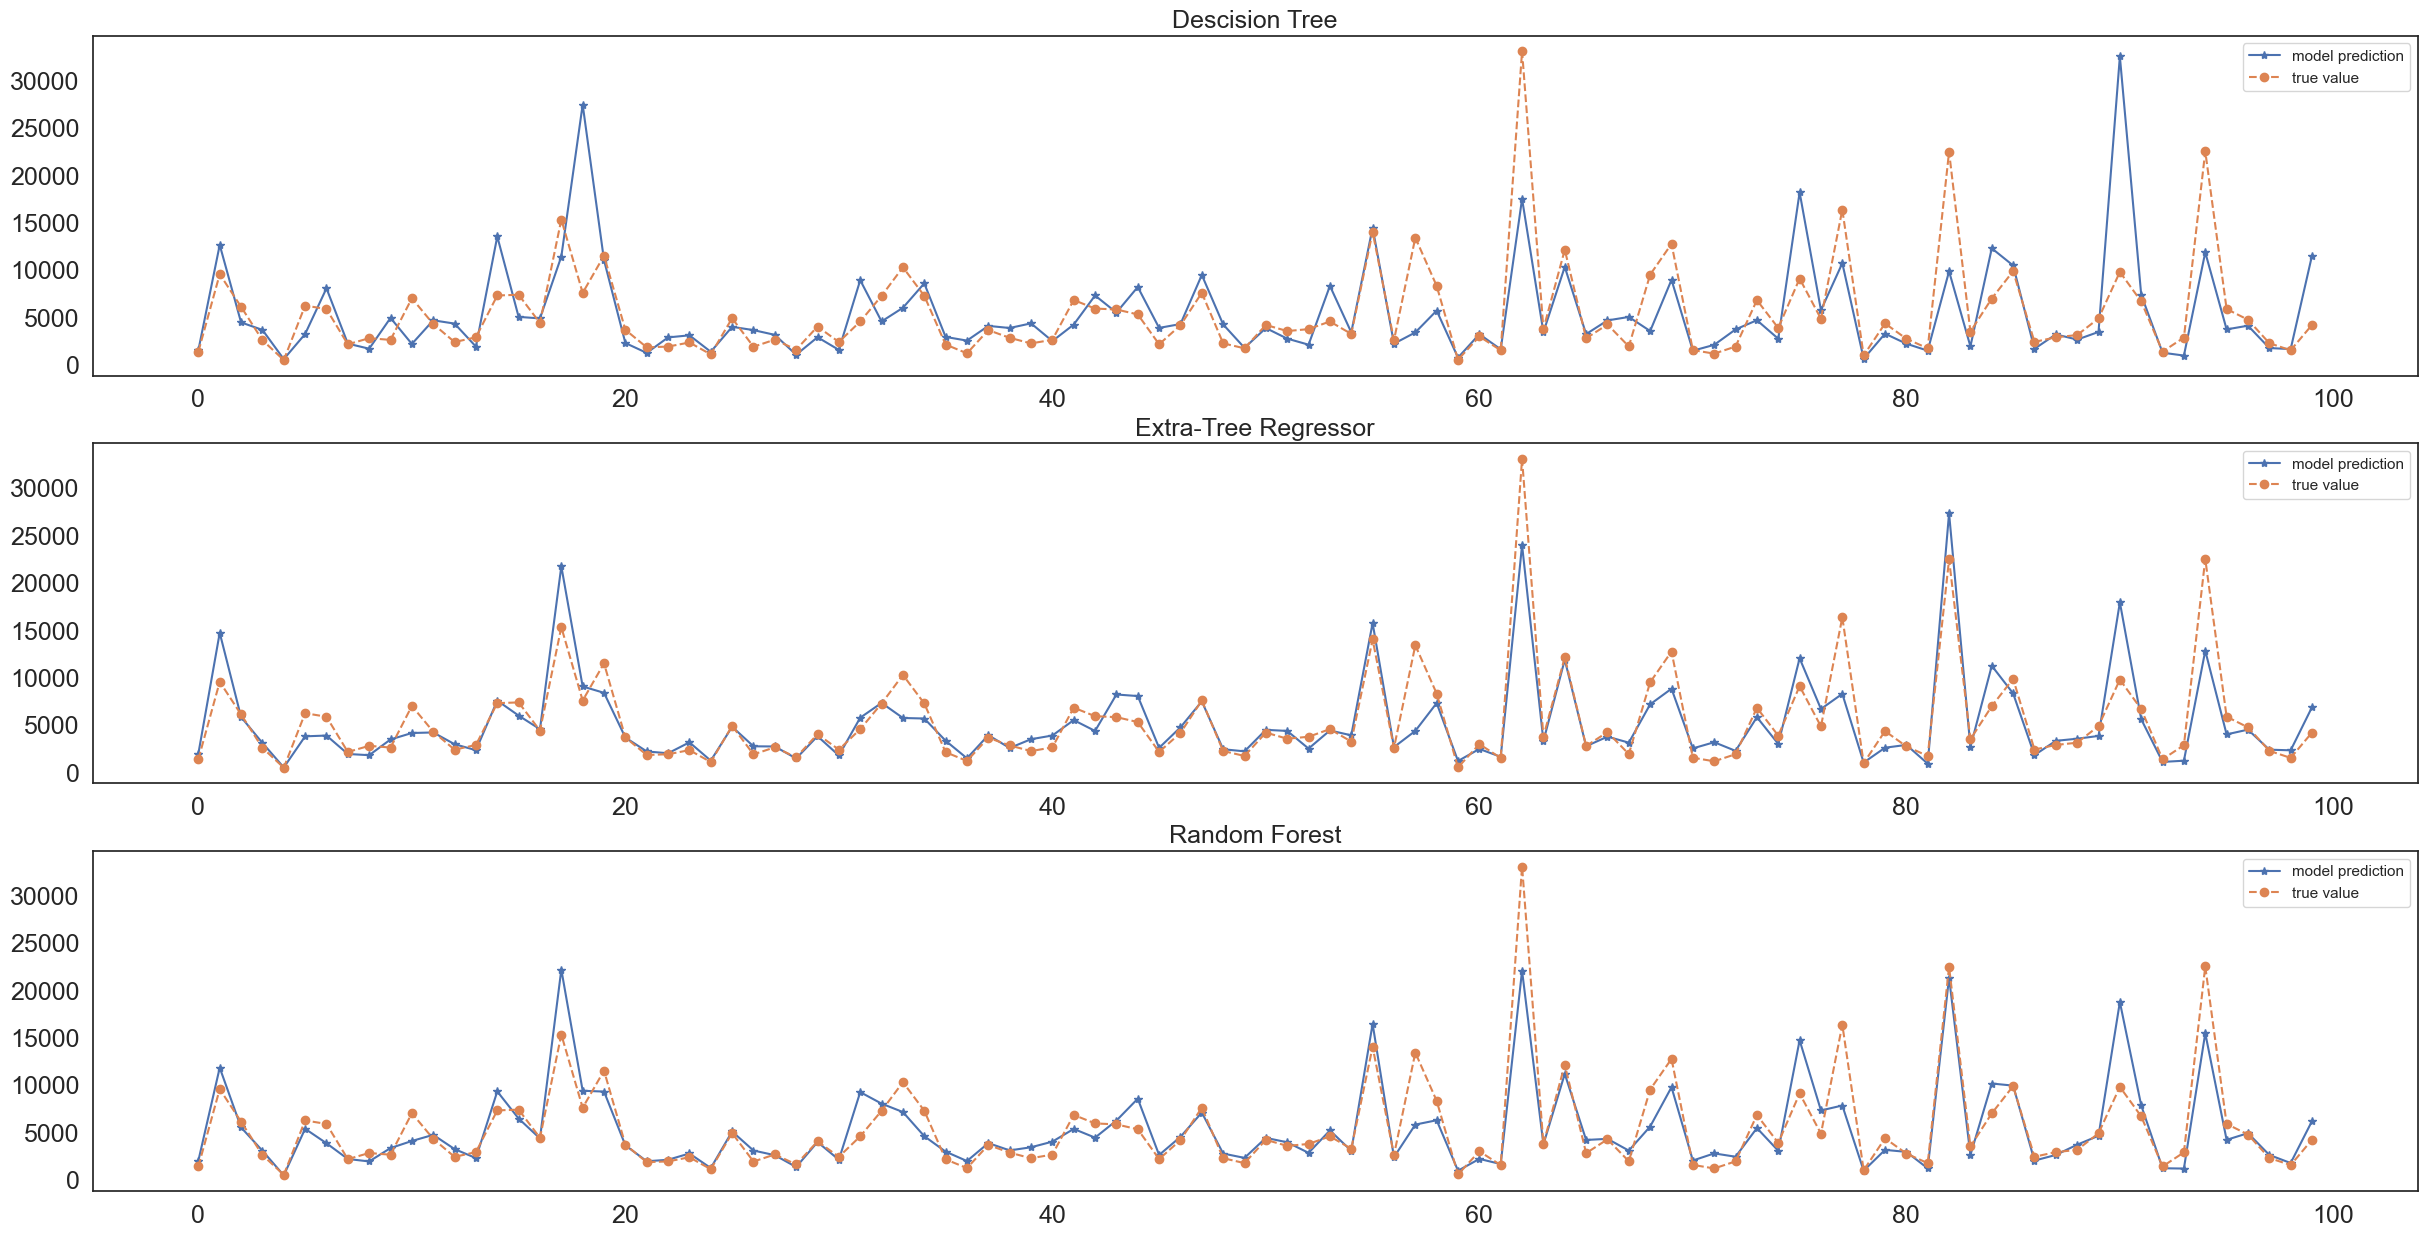

In [57]:
print_results(labels = ["Descision Tree:", "Extra-Tree Regressor:", "Random Forest:"],
             est = [dtr,etr, rfrr],
             plt_num = 100,
             testing = [tr_x_test, tr_y_test])

Linear Regression: 
R-Squared: -31256972298.124
Root Mean Square Error: 130,237.903
Mean Absolute Error: 6,885.773



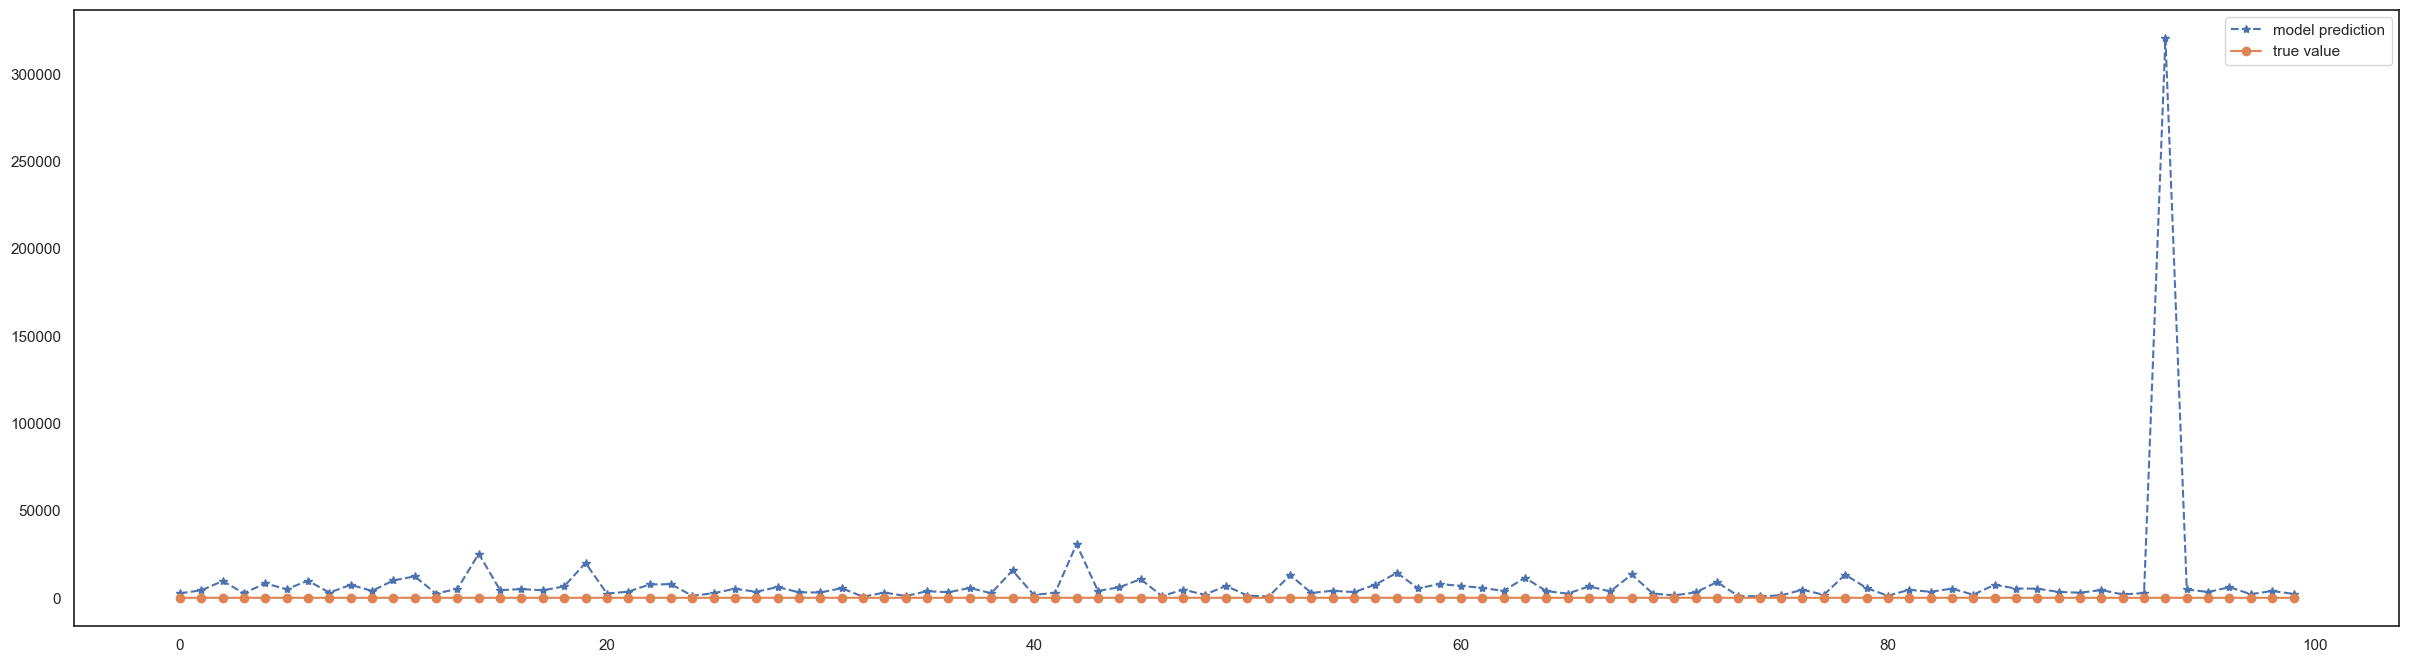

In [58]:
print("Linear Regression: ")

df_labels_prediction = lr.predict(lr_x_test_ppu)
df_labels_prediction =  np.exp(df_labels_prediction) * lr_y_test_ru

print("R-Squared: {:.3f}".format(r2_score(lr_y_test, df_labels_prediction)))
mse = mean_squared_error(lr_y_test,df_labels_prediction) 
mae = mean_absolute_error(lr_y_test, df_labels_prediction)

rmse = np.sqrt(mse)
print("Root Mean Square Error: {:,.3f}".format(rmse))
print("Mean Absolute Error: {:,.3f}".format(mae))
print()

plt.rcParams["figure.figsize"] = (30,8)
plt.plot(range(100), df_labels_prediction[:100],"*--" ,label='model prediction')
plt.plot(range(100), lr_y_test[:100],"o-", label='true value')
plt.legend()

## Hyperparameter Tuning

In [59]:
## Random Search CV
grid_param = [{"etr__n_estimators": randint(low=20, high=60),
               "etr__max_features":randint(low=1, high=6)}]


random_SCV(etr,grid_param,n_iter = 5,cv = 10, file_name = "etr_test_1.pkl", training = [tr_x_train, tr_y_train])


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START etr__max_features=5, etr__n_estimators=26..................
[CV 1/10; 1/5] END etr__max_features=5, etr__n_estimators=26;, score=-0.178 total time=   0.4s
[CV 2/10; 1/5] START etr__max_features=5, etr__n_estimators=26..................
[CV 2/10; 1/5] END etr__max_features=5, etr__n_estimators=26;, score=-0.168 total time=   0.4s
[CV 3/10; 1/5] START etr__max_features=5, etr__n_estimators=26..................
[CV 3/10; 1/5] END etr__max_features=5, etr__n_estimators=26;, score=-0.168 total time=   0.4s
[CV 4/10; 1/5] START etr__max_features=5, etr__n_estimators=26..................
[CV 4/10; 1/5] END etr__max_features=5, etr__n_estimators=26;, score=-0.166 total time=   0.4s
[CV 5/10; 1/5] START etr__max_features=5, etr__n_estimators=26..................
[CV 5/10; 1/5] END etr__max_features=5, etr__n_estimators=26;, score=-0.174 total time=   0.4s
[CV 6/10; 1/5] START etr__max_features=5, etr__n_estimators

test1
R-Squared: 0.385
Root Mean Suqre Error: 5,286.410
Mean Absolute Error: 1,812.592



Pipeline(steps=[('etr',
                 BaggingRegressor(estimator=ExtraTreeRegressor(random_state=42),
                                  max_features=5, n_estimators=26,
                                  random_state=42))])

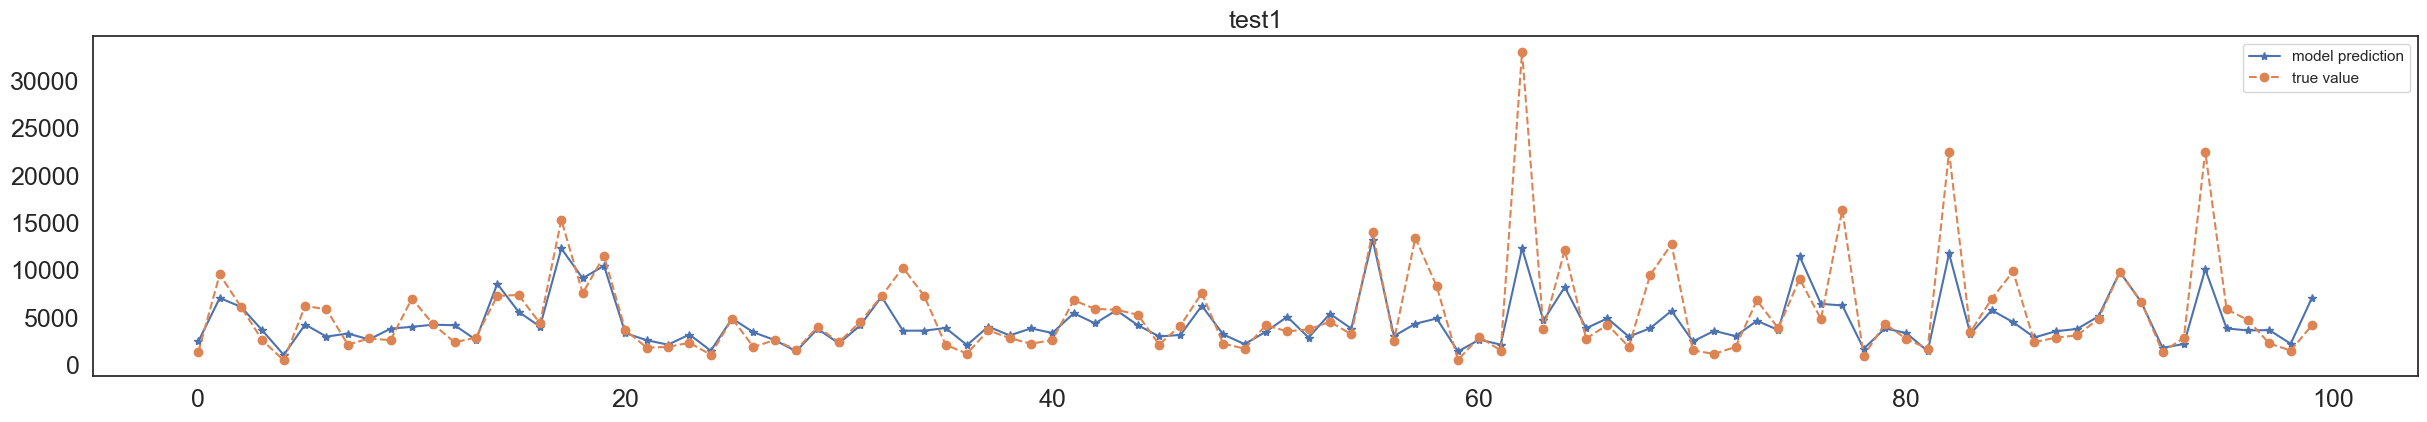

In [60]:
results = wr_pkl_file(file_name = "etr_test_1.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["test1"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [61]:
## Random Search CV
grid_param = [{"dtr__max_depth": randint(low=20, high=60),
               "dtr__min_samples_split":randint(low=2, high=6),
               "dtr__min_samples_leaf": randint(low = 2, high = 10)}]


random_SCV(dtr,grid_param,n_iter = 5,cv = 10, file_name = "dt_test_1.pkl", training = [tr_x_train, tr_y_train])


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5
[CV 1/10; 1/5] END dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5;, score=-0.199 total time=   0.1s
[CV 2/10; 1/5] START dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5
[CV 2/10; 1/5] END dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5;, score=-0.185 total time=   0.1s
[CV 3/10; 1/5] START dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5
[CV 3/10; 1/5] END dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5;, score=-0.187 total time=   0.1s
[CV 4/10; 1/5] START dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5
[CV 4/10; 1/5] END dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5;, score=-0.184 total time=   0.1s
[CV 5/10; 1/5] START dtr__max_depth=51, dtr__min_samples_leaf=4, dtr__min_samples_split=5
[

Decision Tree Random Search CV
R-Squared: 0.506
Root Mean Suqre Error: 4,737.491
Mean Absolute Error: 1,805.835



Pipeline(steps=[('dtr',
                 DecisionTreeRegressor(max_depth=27, min_samples_leaf=8,
                                       min_samples_split=4))])

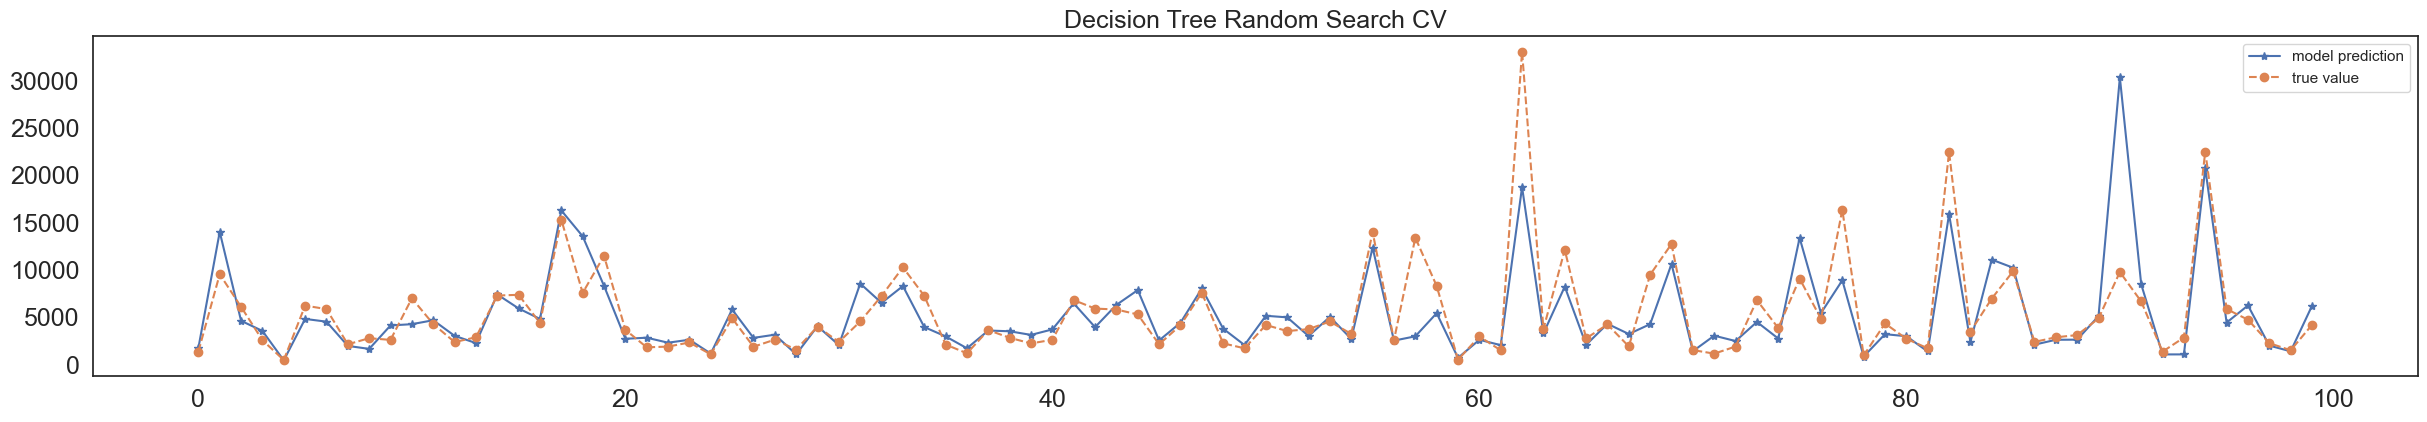

In [62]:
results = wr_pkl_file(file_name = "dt_test_1.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Decision Tree Random Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [63]:
# Random Search CV

grid_param = [{"rfregression__n_estimators": randint(low=20, high=100),
               "rfregression__min_samples_leaf":randint(low=2, high=30)}]


random_SCV(rfrr,grid_param,n_iter = 5,cv = 10, file_name = "rfr_test_2.pkl", training = [tr_x_train, tr_y_train])


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV 1/10; 1/5] START rfregression__min_samples_leaf=14, rfregression__n_estimators=34
[CV 1/10; 1/5] END rfregression__min_samples_leaf=14, rfregression__n_estimators=34;, score=-0.120 total time=   0.2s
[CV 2/10; 1/5] START rfregression__min_samples_leaf=14, rfregression__n_estimators=34
[CV 2/10; 1/5] END rfregression__min_samples_leaf=14, rfregression__n_estimators=34;, score=-0.117 total time=   0.2s
[CV 3/10; 1/5] START rfregression__min_samples_leaf=14, rfregression__n_estimators=34
[CV 3/10; 1/5] END rfregression__min_samples_leaf=14, rfregression__n_estimators=34;, score=-0.116 total time=   0.2s
[CV 4/10; 1/5] START rfregression__min_samples_leaf=14, rfregression__n_estimators=34
[CV 4/10; 1/5] END rfregression__min_samples_leaf=14, rfregression__n_estimators=34;, score=-0.113 total time=   0.2s
[CV 5/10; 1/5] START rfregression__min_samples_leaf=14, rfregression__n_estimators=34
[CV 5/10; 1/5] END rfregression__min_

Random Forest Random Search CV
R-Squared: 0.590
Root Mean Suqre Error: 4,313.968
Mean Absolute Error: 1,498.158



Pipeline(steps=[('rfregression',
                 RandomForestRegressor(min_samples_leaf=11, n_estimators=81,
                                       n_jobs=-1, random_state=42))])

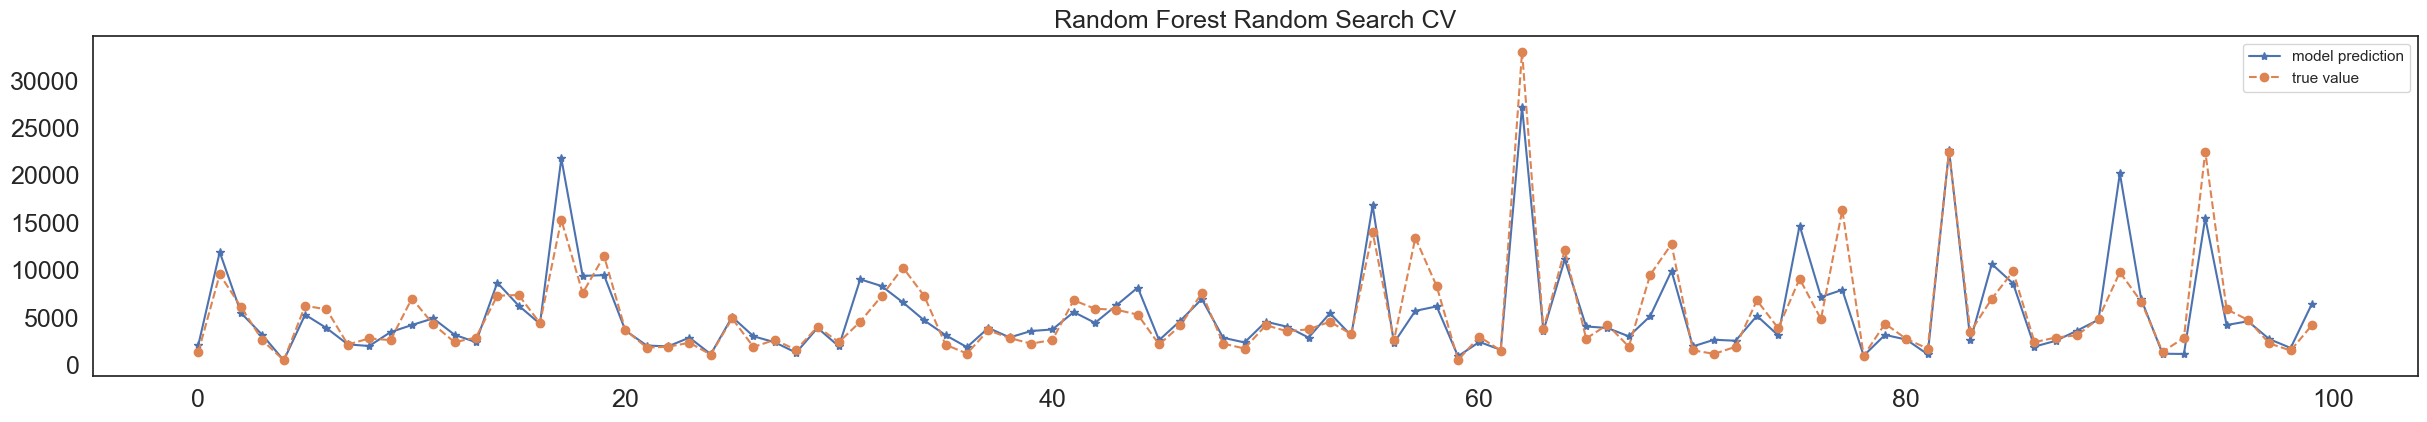

In [64]:
results = wr_pkl_file(file_name = "rfr_test_2.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Random Forest Random Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
best_estimator

In [65]:
## Grid Search CV
grid_param = [{"rfregression__n_estimators": [76,77,78],
               "rfregression__min_samples_leaf":[3]}]


grid_SCV(pipe = rfrr, grid_param = grid_param, 
         cv = 10, 
         scoring = 'neg_mean_squared_error', 
         file_name = "rfr_grid_test_2.pkl", training = [tr_x_train, tr_y_train])

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 1/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.116 total time=   0.6s
[CV 2/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 2/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.114 total time=   0.7s
[CV 3/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 3/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.113 total time=   0.7s
[CV 4/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 4/10; 1/3] END rfregression__min_samples_leaf=3, rfregression__n_estimators=76;, score=-0.109 total time=   0.7s
[CV 5/10; 1/3] START rfregression__min_samples_leaf=3, rfregression__n_estimators=76
[CV 5/10; 1/3] END rfregression__min_samples_l

Random Forest Grid Search CV
R-Squared: 0.602
Root Mean Suqre Error: 4,253.906
Mean Absolute Error: 1,489.239



{'rfregression__min_samples_leaf': 3, 'rfregression__n_estimators': 76}

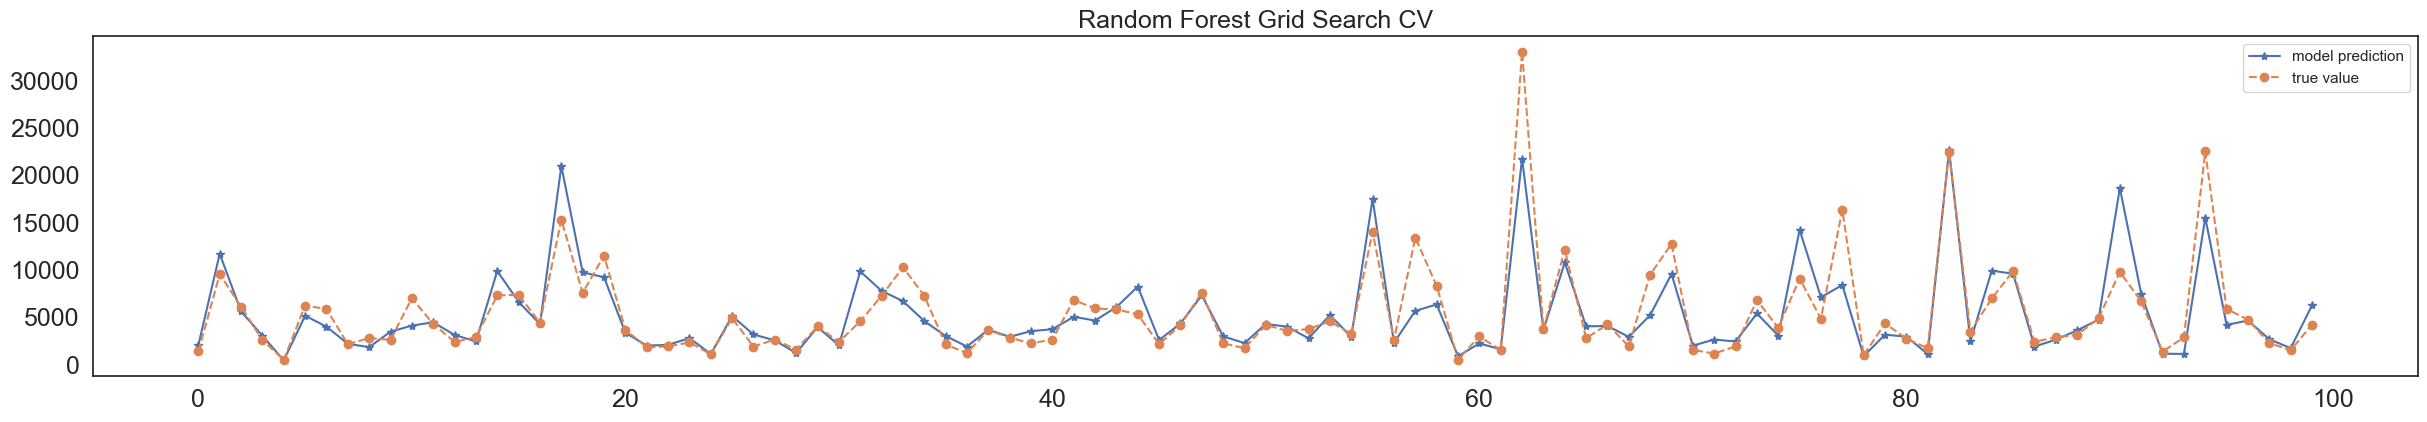

In [47]:
results = wr_pkl_file(file_name = "rfr_grid_test_2.pkl", read = True)
best_estimator = results.best_estimator_
# predictions = best_estimator.predict(x_test)
print_results(["Random Forest Grid Search CV"], best_estimator, testing = [tr_x_test, tr_y_test], plt_num = 100)
results.best_params_